In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
from icecream import ic

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     "wa-sa-A2", "wa-sa-B4",
                                     "wa-sa-C4",
                                     "wa-sa-B3",  "wa-sa-B2",
                                     "wa-sa-A5", "wa-sa-A3",
                                     "wa-sa-C2",
                                     "wa-sa-C3", # Pos
                                     "wa-sa-D3", # Zero
                                     "wa-sa-D4", 
                                     "wa-sa-B1", "wa-sa-A4",
                                     "wa-sa-A1", "wa-sa-D2",
                                     "wa-sa-C5", # Pos
                                     "wa-sa-D5", # Zero
                                     "wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
decision = decision_lib.ClusterHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     eps=0.35,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa)

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.029780691106255565, n_outlier: 368

Total error rate: 0.000792393026941363
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000083          0.0   0.004504        0.0   0.000167      0.0

False negative rate: 1.3901632051602858e-05
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000083          0.0        0.0        0.0        0.0      0.0

True negative rate: 0.8128840325854255
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.735591     0.756193   0.871799   0.899908   0.779798 0.834015

Precision (TP / (TP + FP)): 0.995839215394903
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0   0.964867        1.0   0.999242      1.0

Recall (TP / (TP + FN)): 0.9999253954043569
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999685          1.0        1.0        1.0        1.0      1.0

Accuracy ((TP + TN) / (P + N)): 0.8428254828156331


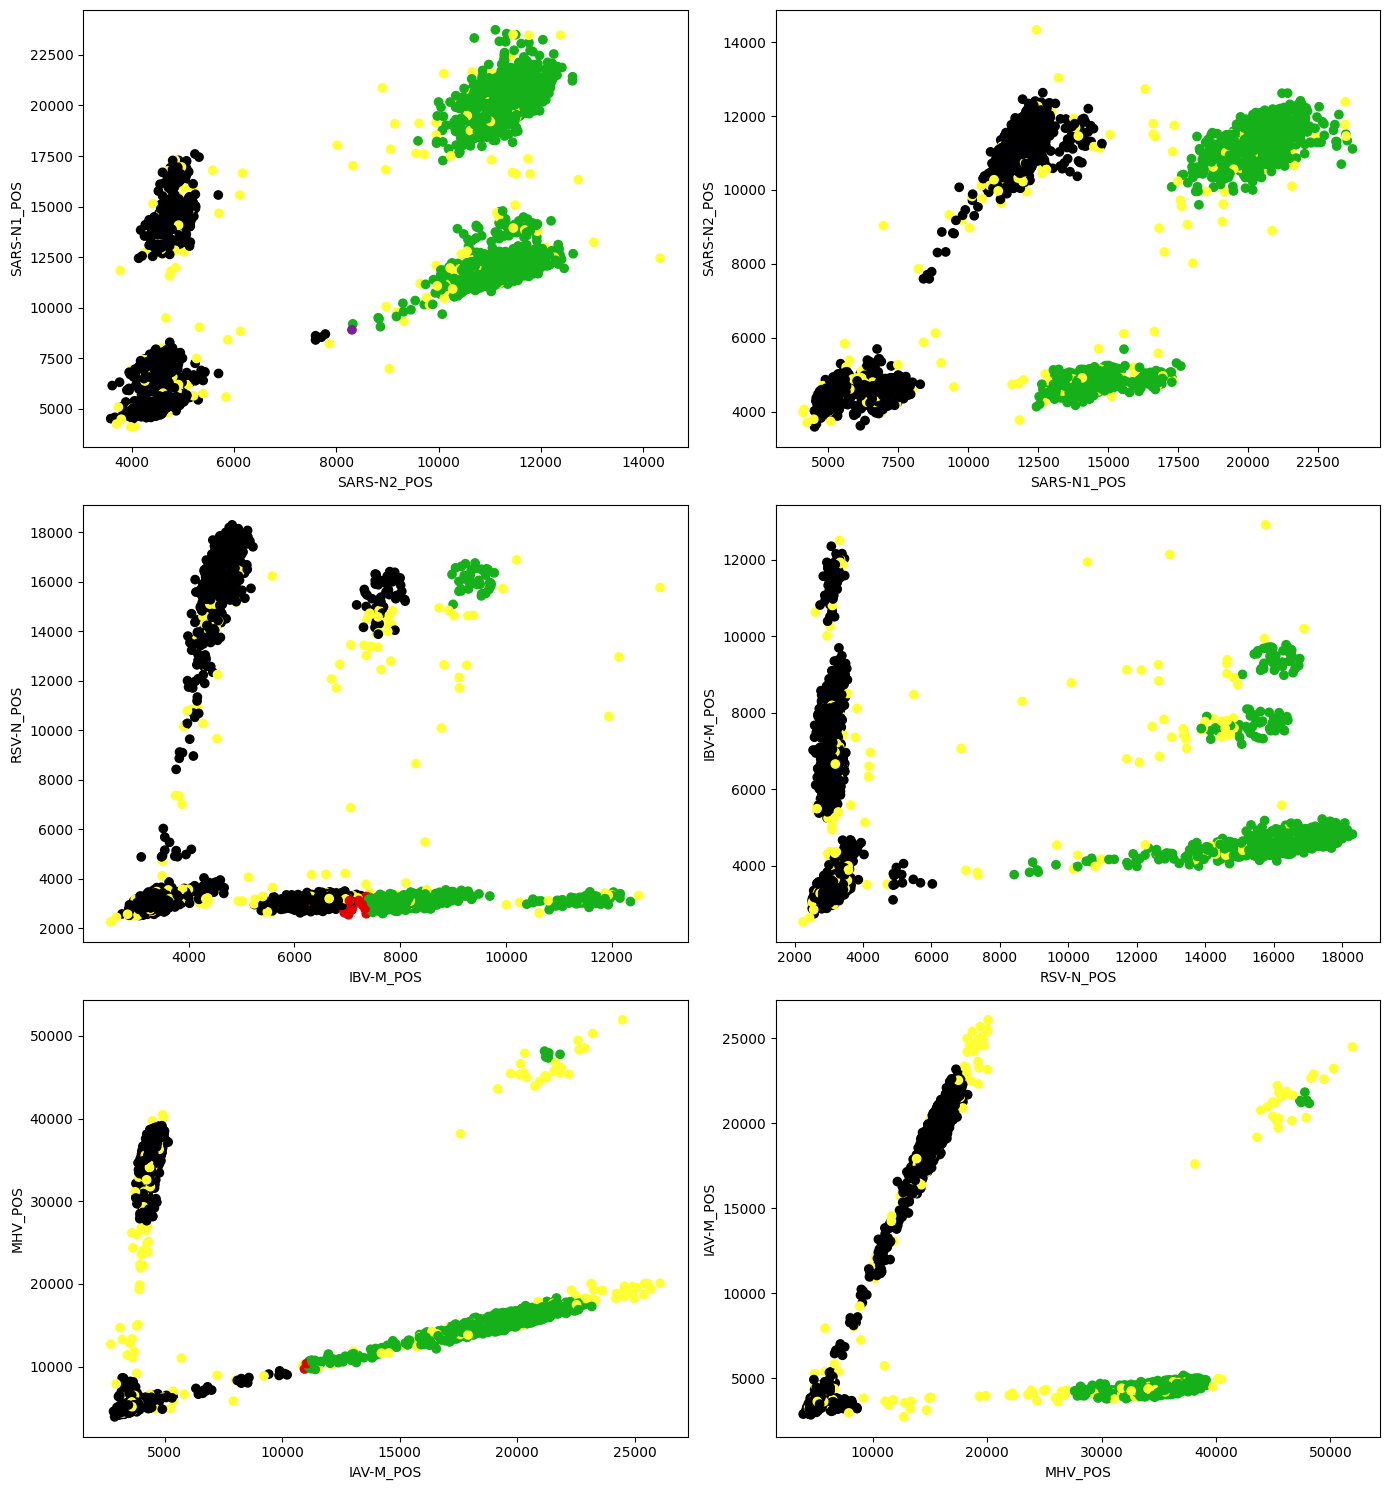

In [5]:

df_data_points = pd.DataFrame(data=decision.X_no_neg, columns=prediction_axis) 
df_predictions = df_decision.iloc[decision.mask,:]
df_ground_trouth = df_wa.iloc[decision.mask,6:]
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        )